<a href="https://colab.research.google.com/github/benwulmer/CDA/blob/main/2_Teleconnections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teleconnections

In the introduction notebook, we analyzed the 500mb geopotential height anomaly over the North Atlantic during the wettest month on record. We observed that extreme precipitation events can be associated with distinctive patterns in the atmospheric circulation.

In other words, weather patterns at one location can be correlated with weather patterns at another distant location. This is called a *teleconnection*.

To quantify teleconnections, we will perform an Empirical Orthogonal Function (EOF) analysis using the surface pressure and sea surface temperature. This will lead us to an idenfication of two important climate patterns, the North Atlantic Oscillation (NAO) and the El Nino Southern Oscillation (ENSO).

In [5]:
# First install the required packages for the notebook.  If you just ran notebook 1, you shouldn't need to do this.
import os

# Install required packages
%pip install -q earthkit-data cdsapi xarray netcdf4 matplotlib cartopy numpy regionmask xeofs

# ==========================================
# ENTER YOUR CDS API KEY HERE
# ==========================================
CDS_URL = 'https://cds.climate.copernicus.eu/api'
CDS_API_KEY = '1b97f6c6-26b8-45a5-8e27-5e8360276f64'  # Replace with your actual API key (format: xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx)

# Set as environment variables for earthkit
os.environ['CDSAPI_URL'] = CDS_URL
os.environ['CDSAPI_KEY'] = CDS_API_KEY

## Part 1: North Atlantic Oscillation

 Surface pressure is a key indicator of atmospheric circulation patterns, and the North Atlantic Oscillation (NAO) is particularly evident in surface pressure variability.

 An EOF analysis, also known as Principal Component Analysis (PCA), is a statistical technique that identifies the dominant spatial patterns of variability in a dataset.

 Before we start, let's load in the required libraries

In [2]:
# First, import the required libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from xeofs.single import EOF
import earthkit.data
import warnings
warnings.filterwarnings('ignore')

First, let's download the monthly mean sea level pressure data. We use the same North Atlantic region that we analyzed in `ERA5_Introduction.ipynb`. This region captures important atmospheric variability patterns including the North Atlantic Oscillation (NAO).

Surface pressure (or mean sea level pressure - MSLP) is an excellent variable for studying atmospheric circulation patterns because it directly reflects the large-scale pressure systems that drive weather.

In [16]:
# Set some paramters
# North Atlantic region [North, West, South, East]
MIN_LAT = 35
MIN_LONG = -135
MAX_LAT = 55
MAX_LONG = -115

BOUNDS = [MAX_LAT, MIN_LONG, MIN_LAT, MAX_LONG]

# Time period.  Here just use the satellite era
START_YEAR = 1979
END_YEAR = 2024

# Download mean sea level pressure - all months for the full time period
dataset = "reanalysis-era5-single-levels-monthly-means"

years = [str(y) for y in range(START_YEAR, END_YEAR + 1)]
months = [f"{m:02d}" for m in range(1, 13)]

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["mean_sea_level_pressure"],
    "year": years,
    "month": months,
    "time": "00:00",
    "area": BOUNDS,
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading mean sea level pressure data for {START_YEAR}-{END_YEAR}...")
print("(This may take several minutes)")

mslp_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

print("Done downloading data")

(This may take several minutes)


2026-01-29 10:10:39,055 INFO Request ID is b0c2427a-32dc-4ecb-8b76-e9c5c444d515
INFO:ecmwf.datastores.legacy_client:Request ID is b0c2427a-32dc-4ecb-8b76-e9c5c444d515
2026-01-29 10:10:39,201 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-01-29 10:10:53,126 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2026-01-29 10:11:01,433 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ff39c31136a659da52afc8a67e3eca92.nc:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

Done downloading data


Since the surface pressure contains a lot of data, we load it into memory using the xarray `.compute` operation. Without doing this, xarray will build a 'computation graph' when we call operations, and the calculations won't actually be done until data is needed. Using `.compute` here doesn't actually calculate anything in this case, it just loads the data into a numpy array and ensures that the data is loaded into memory to speed up the calculations later.

In [8]:
# Extract mean sea level pressure and convert from Pa to hPa
mslp = mslp_data.msl / 100.0  # Pa to hPa

# Load the dataset into memory using the xarray compute operation
mslp = mslp.compute()

To identify patterns of interannual variability, we need to remove the seasonal cycle. We do this by:
1. Calculating the monthly climatology (average January, average February, etc.)
2. Subtracting the climatology from each month to get anomalies

In [9]:
# Calculate monthly climatology using groupby
# This calculates the average for each calendar month (Jan, Feb, ..., Dec)
mslp_climatology = mslp.groupby('valid_time.month').mean(dim='valid_time')

# Calculate anomalies by subtracting the climatology for each month
mslp_anomaly = mslp.groupby('valid_time.month') - mslp_climatology

Grid cells at higher latitudes represent smaller areas on Earth. To give each region appropriate weight in our EOF analysis, we multiply by the square root of the cosine of latitude.

In [10]:
# Apply latitude weighting for EOF analysis
lat_weights = np.cos(np.deg2rad(mslp_anomaly.latitude))
lat_weights = lat_weights / lat_weights.mean()  # Normalize

mslp_weighted = mslp_anomaly * np.sqrt(lat_weights)


Now we perform EOF analysis to identify the dominant patterns of sea level pressure variability over the North Atlantic.

We use the `xeofs` package, which is specifically designed to perform an EOF analysis efficiently on xarray data.

In [11]:
# Prepare data for EOF analysis
# xeofs works directly with xarray DataArrays and handles dimensions automatically
n_eofs = 4

# Create and fit EOF model
# The model will use the time dimension for decomposition and spatial dims for patterns
model = EOF(n_modes=n_eofs, standardize=False, use_coslat=False)  # We already applied weights
model.fit(mslp_weighted, dim='valid_time')

# Get the EOFs (spatial patterns) and PCs (time series)
eofs = model.components()  # Spatial patterns
pcs = model.scores()  # Principal components (time series), standardized
variance_fractions = model.explained_variance_ratio()  # Fraction of variance explained

print("\nVariance explained by each EOF:")
for i in range(n_eofs):
    print(f"  EOF {i+1}: {variance_fractions.values[i]*100:.1f}%")
print(f"\nTotal variance explained by first {n_eofs} EOFs: {variance_fractions.values.sum()*100:.1f}%")


Variance explained by each EOF:
  EOF 1: 75.3%
  EOF 2: 13.1%
  EOF 3: 6.4%
  EOF 4: 2.0%

Total variance explained by first 4 EOFs: 96.9%


The spatial patterns show the characteristic structures of atmospheric variability over the North Atlantic. Let's plot the four leading EOFs.

[35, 55, -135, -115]
[35, 55, -135, -115]
[35, 55, -135, -115]
[35, 55, -135, -115]


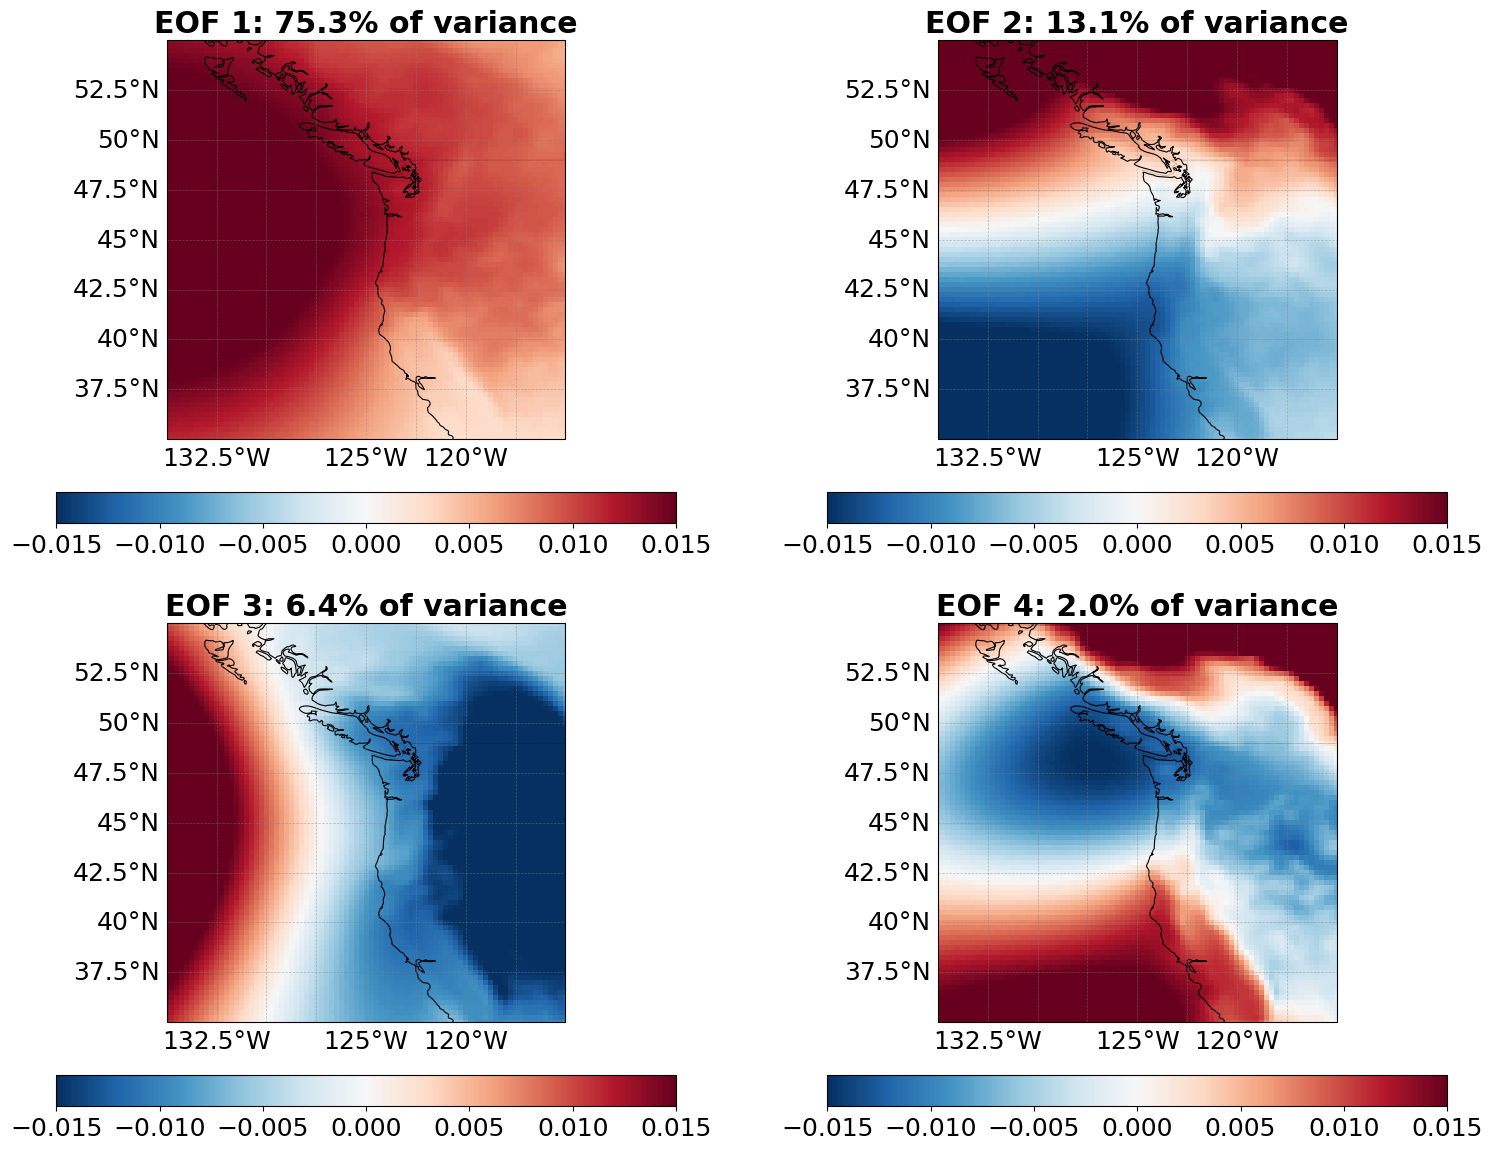


Plot saved as 'eof_patterns.png'


In [17]:
# Plot the 4 leading EOFs
fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Set the default font and figure size
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 18

for i in range(n_eofs):
    ax = axes[i]
    eof_pattern = eofs.sel(mode=i+1)  # xeofs uses 1-based indexing

    # Set map extent
    ax.set_extent([BOUNDS[1], BOUNDS[3],
                   BOUNDS[2], BOUNDS[0]],
                  crs=ccrs.PlateCarree())

    # Plot EOF pattern
    im = ax.pcolormesh(
        eof_pattern.longitude,
        eof_pattern.latitude,
        eof_pattern.values,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmin=-0.015, vmax=0.015
    )

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Title with variance explained
    ax.set_title(f'EOF {i+1}: {variance_fractions.values[i]*100:.1f}% of variance', fontweight='bold')

    # Add colorbar
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)

plt.tight_layout()
plt.savefig('eof_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'eof_patterns.png'")

### Interpreting the EOFs

The leading order EOF (EOF1) shows a pattern called the North Atlantic Oscillation (NAO). This dipole pattern (with centers near Iceland and the Azores) is the dominant mode of atmospheric variability in the North Atlantic and explains a significant fraction of the variance in sea level pressure.

At a given time, we can project the sea level pressure anomaly onto the EOFs. The resulting *principal components* tell us the amplitude of each of the EOF modes at that time. In this case we call the timeseries of the principal component associated with the first EOF the *NAO index*.

Next, let's plot the first principal component as a function of time.

In [ ]:
# Plot the Principal Component time series for EOF1
fig, ax = plt.subplots(figsize=(14, 5))

pc1 = pcs.sel(mode=1)  # xeofs uses 1-based indexing (mode 1 = first EOF)

# Restrict to 2020-2024
pc1_recent = pc1.sel({'valid_time': slice('2020', '2024')})
times = pc1_recent['valid_time'].values

# Plot as line with markers
ax.plot(times, pc1_recent.values, color='#2E86AB', linewidth=2,
        marker='o', markersize=6, label='NAO Index')
ax.axhline(y=0, color='black', linewidth=0.5)

ax.set_xlabel('Year')
ax.set_ylabel('PC1 (standardized)')
ax.set_title('Principal Component 1 Time Series (NAO Index)', fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pc1_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved as 'pc1_timeseries.png'")

Notice how the NAO index is very large and negative in February 2020 which was the wettest month on record in the UK.

Next, let's examine how the leading EOF (NAO pattern) relates to precipitation anomalies across the Nort Atlantic region more broadly.

We start by downloading the monthly precipitation data for our pre-defined North Atlantic region. Then, we calculate teh monthly climatology (again, using the groupby operation) and the anomaly, or the departure from the monthly climatology.

In [ ]:
# Download precipitation data for the same region and time period
dataset = "reanalysis-era5-single-levels-monthly-means"

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["total_precipitation"],
    "year": years,
    "month": months,
    "time": "00:00",
    "area": NORTH_ATLANTIC_REGION,
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading precipitation data for {START_YEAR}-{END_YEAR}...")
print("(This may take several minutes)")

precip_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

print("done downloading precipitation data")

# Extract precipitation and convert to mm
precip = precip_data.tp * 1000  # meters to mm

# Calculate monthly climatology and anomalies for precipitation
precip_climatology = precip.groupby('valid_time.month').mean(dim='valid_time')
precip_anomaly = precip.groupby('valid_time.month') - precip_climatology

Now, calculate the correlation between the NAO index (PCA1) and the precipitation anomaly at every point in our North Atlantic region, and plot a map of the result.

In [ ]:
# Calculate correlation between PC1 and precipitation anomaly at each grid point
# Using vectorized xarray operations (much faster than nested loops!)

# Get PC1 values as a simple array
pc1_values = pcs.sel(mode=1).values  # xeofs uses 1-based indexing

# Get precipitation anomaly values
precip_values = precip_anomaly.values

# Create a new DataArray for PC1 with matching time coordinate
# This ensures proper broadcasting for correlation
pc1_da = xr.DataArray(
    pc1_values,
    dims=['valid_time'],
    coords={'valid_time': precip_anomaly['valid_time']}
)

# Use xarray's built-in correlation function
corr_da = xr.corr(pc1_da, precip_anomaly, dim='valid_time')

# Plot correlation map
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([NORTH_ATLANTIC_REGION[1], NORTH_ATLANTIC_REGION[3],
               NORTH_ATLANTIC_REGION[2], NORTH_ATLANTIC_REGION[0]],
              crs=ccrs.PlateCarree())

# Plot correlation
im = ax.pcolormesh(
    corr_da.longitude,
    corr_da.latitude,
    corr_da.values,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    vmin=-0.6, vmax=0.6
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='#333333')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':', edgecolor='#666666')
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', alpha=0.3)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                  alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Correlation Coefficient', fontsize=12)

# Title
ax.set_title(f'Correlation: NAO Index (Sea Level Pressure EOF1) vs Precipitation Anomaly\n'
             f'{START_YEAR}-{END_YEAR}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('NAO_precipitation_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'NAO_precipitation_correlation.png'")

### Interpreting the Correlation Map

**Green/positive correlations**: When the NAO index is positive, precipitation is above normal where the correlation is positive.

**Brown/negative correlations**: When NAO index is positive, precipitation is below normal where the correlation is negative.

We see that during positive NAO phases we get high preciptation across southern Europe and the Mediterranean and dry conditions across northern Europe and Iceland. The opposite happens during periods of negative NAO.

Notice how, unlike Europe, precipitation in North America is relatively unaffected by the pressure change associated with the NAO. Although correlation does not guarantee causation, we can combine dynamical insight into atmospheric circulation with data to understand climate interactions and feedbacks. Here, the dipole structure in pressure anomaly shifts the location and strength of the jet stream (in geostrophic balance) and the storm tracks which bring moisture and precipitation to Europe.

---

## Part 2: El Niño-Southern Oscillation (ENSO)

In this section we will explore a second teleconnection in the climate system. This teleconnection involves the ocean sea surface temperature (SST), and the analysis gives an example of how to deal with missing data (in the case of SST thes are land points.)

The El Niño-Southern Oscillation (ENSO) is the most important mode of interannual climate variability on Earth. It originates in the tropical Pacific Ocean but has global impacts on weather patterns, including precipitation and temperature across multiple continents. The phase of ENSO with warm temperatures in the tropical Pacific is called El Niño, while the cold phase is called La Niña.

Below, we will perform an EOF analysis on SST anomalies in the tropical Pacific region and explore the correlation between the leading EOF (ENSO index) and global precipitation.

In [ ]:
# Configuration for ENSO analysis
# Tropical Pacific region [North, West, South, East]
# This covers the region where ENSO is most prominent
TROPICAL_PACIFIC = [30, 120, -30, 290]  # 30°S to 30°N, 120°E to 70°W

# Time period (same as NAO analysis)
START_YEAR = 1979
END_YEAR = 2024

# Download sea surface temperature data for the tropical Pacific
dataset = "reanalysis-era5-single-levels-monthly-means"

years = [str(y) for y in range(START_YEAR, END_YEAR + 1)]
months = [f"{m:02d}" for m in range(1, 13)]

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["sea_surface_temperature"],
    "year": years,
    "month": months,
    "time": "00:00",
    "area": TROPICAL_PACIFIC,
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading SST data for tropical Pacific...")
print(f"  Years: {START_YEAR}-{END_YEAR}")
print(f"  Region: {TROPICAL_PACIFIC}")
print("  (This may take several minutes)")

sst = earthkit.data.from_source("cds", dataset, request).to_xarray()

print("Done downloading SST data")

Next, we load the SST data into memory and calculate the monthly climatology and the departure (anomaly) from the monthly mean.

In [ ]:
# Load SST data into memory to speed up subsequent operations
sst = sst.compute()

# Calculate monthly climatology
sst_climatology = sst.groupby('valid_time.month').mean(dim='valid_time')

# Calculate anomalies
sst_anomaly = sst.groupby('valid_time.month') - sst_climatology

Of course the sea surface temperature isn't defined over points with land. In the ERA5 dataset, the SST variable is given NaN (not a number) values where data is missing. The NaN values will cause problems when we calculate the EOFs. To avoid this we want to remove the NaN points. To do this, we 'mask' out the NaN values.

In [ ]:
print("Calculating EOFs...")
# Perform EOF analysis on SST anomalies
# Small fix for partial NaNs: identify points that are valid (not NaN) for ALL time steps
valid_mask = sst_anomaly.notnull().all(dim='valid_time')
sst_anomaly_clean = sst_anomaly.where(valid_mask)

# xeofs automatically handles:
# 1. Weighting by cosine of latitude (use_coslat=True)
# 2. Missing data (fully-masked points) by skipping them
n_enso_eofs = 4
enso_model = EOF(n_modes=n_enso_eofs, standardize=False, use_coslat=True)
enso_model.fit(sst_anomaly_clean, dim='valid_time')

# Get EOFs and PCs
enso_eofs = enso_model.components()
enso_pcs = enso_model.scores()
enso_variance = enso_model.explained_variance_ratio()

print("\nVariance explained by each EOF:")
for i in range(n_enso_eofs):
    print(f"  EOF {i+1}: {enso_variance.values[i]*100:.1f}%")
print(f"\nTotal variance explained by first {n_enso_eofs} EOFs: {enso_variance.values.sum()*100:.1f}%")


Now, plot the spatial structure of the leading EOFs. Note that the EOFs are scaled so that they have the same amplitude.


In [ ]:
# Plot the 4 leading ENSO EOFs
fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()

for i in range(n_enso_eofs):
    ax = axes[i]
    # Select the i-th mode. xeofs uses 1-based indexing for modes.
    eof_pattern = enso_eofs.sel(mode=i+1)

    # convert to the EOF to an array for plotting
    eof_pattern = eof_pattern.to_array().squeeze()

    # Set map extent to tropical Pacific
    ax.set_extent([TROPICAL_PACIFIC[1]-180, TROPICAL_PACIFIC[3]-180,
                   TROPICAL_PACIFIC[2], TROPICAL_PACIFIC[0]],
                  crs=ccrs.PlateCarree(central_longitude=180))

    # Plot EOF pattern using pcolormesh (standard matplotlib)
    im = ax.pcolormesh(
        eof_pattern.longitude,
        eof_pattern.latitude,
        eof_pattern.values,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmin=-0.01, vmax=0.01
    )

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor='#d3d3d3', alpha=0.8)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False

    ax.set_title(f'EOF {i+1}: {enso_variance.values[i]*100:.1f}% of variance')
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, shrink=0.8, label='EOF amplitude')

plt.tight_layout()

The leading EOF shows the classic ENSO pattern with large SST anomalies in the eastern tropical pacific. The first EOF accounts for 36% of the variance, implying that it is a major component of the SST variability in the tropical Pacific.

The amplitude of the first EOF (the first principle component, or PC1) serves as an ENSO index. PC1>0 indicates El Niño conditions (warm SST anomalies in the central/eastern Pacific), while negative values indicate La Niña conditions (cold SST anomalies).

Plot a timeseries of the ENSO index.

In [ ]:
# Plot the ENSO index (PC1) time series
fig, ax = plt.subplots(figsize=(14, 5))

enso_pc1 = enso_pcs.sel(mode=1)
enso_times = enso_pc1['valid_time'].values

# Color positive (El Niño) and negative (La Niña) differently
ax.fill_between(enso_times, 0, enso_pc1.values, where=enso_pc1.values >= 0,
                color='#E94F37', alpha=0.7, label='El Niño (warm)')
ax.fill_between(enso_times, 0, enso_pc1.values, where=enso_pc1.values < 0,
                color='#3498DB', alpha=0.7, label='La Niña (cold)')
ax.axhline(y=0, color='black', linewidth=0.5)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('ENSO Index (standardized)', fontsize=12)
ax.set_title('ENSO Index: Principal Component 1 of Tropical Pacific SST', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enso_index_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved as 'enso_index_timeseries.png'")


Like the NAO, ENSO isn't a regular oscillation. Still, there is a characteristic period of roughly 3-5 years when conditions shift from one phase to another.

ENSO has significant impacts on precipitation patterns around the world. Let's download global precipitation data and calculate the correlation between the ENSO index and precipitation anomalies.


In [ ]:
# Download global precipitation data
# We'll use a coarser resolution to speed things up
GLOBAL_REGION = [60, -180, -60, 180]  # Global tropics and subtropics

dataset = "reanalysis-era5-single-levels-monthly-means"

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["total_precipitation"],
    "year": years,  # Same years as ENSO analysis
    "month": months,
    "time": "00:00",
    "area": GLOBAL_REGION,
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading global precipitation data...")
print(f"  Years: {START_YEAR}-{END_YEAR}")
print(f"  Region: {GLOBAL_REGION}")
print("  (This may take several minutes)")

global_precip_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

print("Done downloading precipitation data")

As before, calculate the monthly climatology and the anomaly.

In [ ]:
# Extract precipitation and convert to mm
global_precip = global_precip_data.tp * 1000  # meters to mm

# Load into memory
global_precip = global_precip.compute()

# Calculate monthly climatology and anomalies
global_precip_climatology = global_precip.groupby('valid_time.month').mean(dim='valid_time')
global_precip_anomaly = global_precip.groupby('valid_time.month') - global_precip_climatology


Now, calculate the correlation between the ENSO index (PC1) and the global precipitation anomaly. We will use xarrays built-in correlation function to do this calculation.

In [ ]:
# Convert ENSO PC1 values to an array
enso_pc1_values = enso_pcs.sel(mode=1).values

# Create a new DataArray for ENSO PC1 with matching time coordinate
enso_pc1_da = xr.DataArray(
    enso_pc1_values,
    dims=['valid_time'],
    coords={'valid_time': global_precip_anomaly['valid_time']}
)

# Use xarray's built-in correlation function
enso_corr_da = xr.corr(enso_pc1_da, global_precip_anomaly, dim='valid_time')

Finally, plot a map of the correlation between the ENSO index and the global precipitation anomaly.

In [ ]:
# Plot ENSO-precipitation correlation map
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))

# Plot correlation
im = ax.pcolormesh(
    enso_corr_da.longitude,
    enso_corr_da.latitude,
    enso_corr_da.values,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    vmin=-0.6, vmax=0.6
)

# Add map features (coastlines, country borders, and gridlines)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='#333333')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='#666666')
#ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', alpha=0.3)
gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray',
                  alpha=0.5, linestyle='--')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Correlation Coefficient')

# Title
ax.set_title(f'Correlation: ENSO Index vs Precipitation Anomaly, '
             f'{START_YEAR}-{END_YEAR}', fontweight='bold')

plt.tight_layout()
plt.savefig('enso_precipitation_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'enso_precipitation_correlation.png'")


The correlation map shows the remarkably wide-ranging impacts that ENSO has on global precipitation. Green colors in the map indicate above normal precipitation during El Niño conditions (positive correlation) and brown colors show below normal precipitation during El Niño conditions (negative correlation). Conversely, during La Niña conditions the precipitation is below normal in green regions and above normal in brown regions.

Perhaps not surprinsingly, preciptiation in the tropical Pacific is strongly affected by ENSO with high preciptation across the region of high SSTs in El Niño conditions. El Niño conditions typically bring dry conditions to Indonesia and neighboring countries, sometimes leading to drought and wildfires.

Africa and North and South America are also influenced by ENSO, although the correlation coefficient is more modest (I remember a particularly wet winter in California in 1997/98 during a strong El Niño.)

Hopefully this notebook showed you how to identify climate oscillations and identify teleconnection patterns associated with them. Depending on what region and climate extreme you select, you might find it useful to analyze some other climate oscillations. Below is a list of some of the major climate oscillations, along with the fields that can be used to identify them. You might also find information on the following website useful: https://psl.noaa.gov/data/climateindices/list/.

| Climate Oscillation | ERA5 Field for Diagnosis | Impacts |
|---------------------|-------------------------|---------------|
| El Niño-Southern Oscillation (ENSO) | Sea surface temperature (SST) in tropical Pacific | Global precipitation patterns, droughts/floods in Indonesia, Australia, South America, Africa; hurricane activity in Atlantic/Pacific |
| North Atlantic Oscillation (NAO) | Sea level pressure (SLP) or 500mb geopotential height in North Atlantic | European winter weather (mild/wet vs cold/dry), North American East Coast storms, Arctic sea ice extent |
| Northern Annular Mode (NAM) | SLP or 500mb geopotential height in Arctic region | Northern Hemisphere winter weather, cold air outbreaks in mid-latitudes, storm tracks |
| Pacific Decadal Oscillation (PDO) | SST in North Pacific | North American climate patterns, salmon populations, drought patterns in western US |
| Indian Ocean Dipole (IOD) | SST in western vs eastern Indian Ocean | Rainfall in East Africa, Australia, and Southeast Asia; affects monsoon patterns |
| Southern Annular Mode (SAM) | SLP or 500mb geopotential height in Southern Hemisphere | Antarctic sea ice, Southern Ocean winds, rainfall in southern Australia and South America |